⚡ Using mps
📂 Train samples: 5710 | Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
📂 Test samples : 1309 | Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
🚀 Using Custom BestCNN

🚀 Training Custom BestCNN...
[Epoch 01] Train Acc=0.4011, Test Acc=0.4706 | Train Loss=1.9268, Test Loss=1.1627 | Test F1=0.4047
💾 New Best Model (F1): 0.4047 at Epoch 1
[Epoch 02] Train Acc=0.5977, Test Acc=0.6646 | Train Loss=1.0371, Test Loss=0.9547 | Test F1=0.6411
💾 New Best Model (F1): 0.6411 at Epoch 2
[Epoch 03] Train Acc=0.6720, Test Acc=0.7273 | Train Loss=0.9428, Test Loss=0.9169 | Test F1=0.6988
💾 New Best Model (F1): 0.6988 at Epoch 3
[Epoch 04] Train Acc=0.7082, Test Acc=0.6845 | Train Loss=0.8885, Test Loss=0.9286 | Test F1=0.6707
[Epoch 05] Train Acc=0.7319, Test Acc=0.7403 | Train Loss=0.8535, Test Loss=0.8151 | Test F1=0.7371
💾 New Best Model (F1): 0.7371 at Epoch 5
[Epoch 06] Train Acc=0.7440, Test Acc=0.7555 | Train Loss=0.8456, Test Loss=0.7803 | Test F1=0.7361
[Epoch 

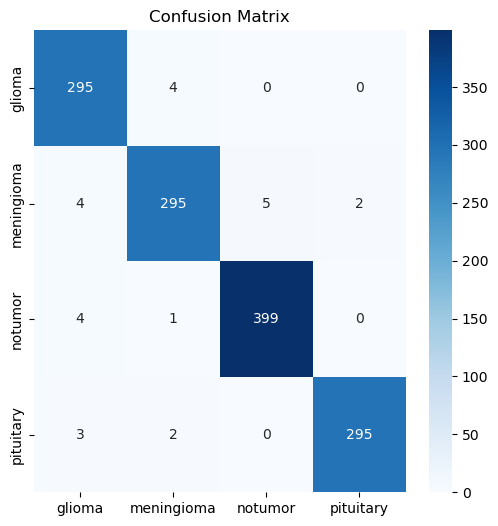

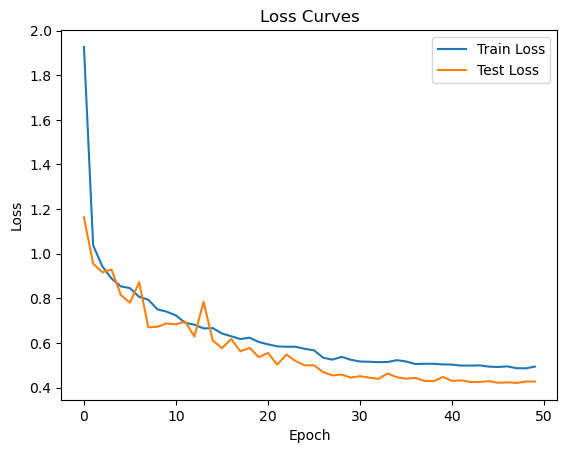

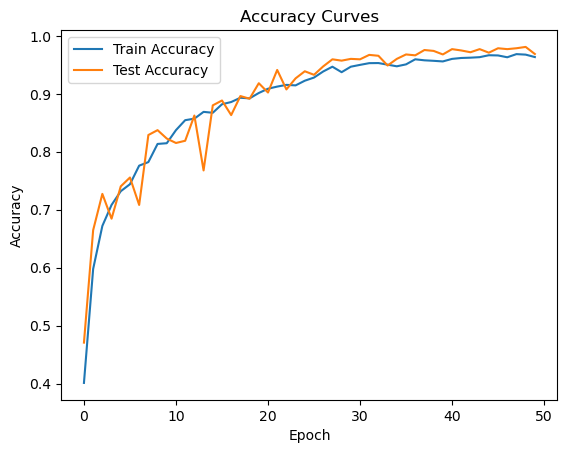

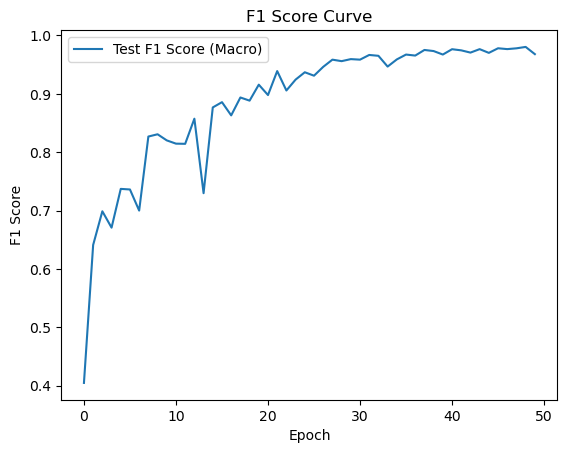

In [3]:
import os, time, warnings, logging
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =====================
# SETTINGS
# =====================
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()

DEVICE = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
logger.info(f"⚡ Using {DEVICE}")

BATCH_SIZE = 32
EPOCHS = 50
IMG_SIZE = 128   # smaller size = fast training on Mac M3
LR = 1e-3
PATIENCE = 5

TRAIN_DIR = r'/Users/muhammadmuhtasimshahriar/Downloads/archive/Training'
TEST_DIR  = r'/Users/muhammadmuhtasimshahriar/Downloads/archive/Testing'

# =====================
# DATA TRANSFORMS
# =====================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# =====================
# DATASETS & CLASSES
# =====================
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
test_dataset  = datasets.ImageFolder(TEST_DIR, transform=test_transform)

logger.info(f"📂 Train samples: {len(train_dataset)} | Classes: {train_dataset.classes}")
logger.info(f"📂 Test samples : {len(test_dataset)} | Classes: {test_dataset.classes}")

num_classes = len(train_dataset.classes)

# =====================
# BALANCED SAMPLER
# =====================
class_counts = np.bincount(train_dataset.targets)
class_weights = 1. / class_counts
samples_weight = [class_weights[t] for t in train_dataset.targets]
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# =====================
# BEST CUSTOM CNN MODEL (mini-VGG style)
# =====================
class BestCNN(nn.Module):
    def __init__(self, num_classes):
        super(BestCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2,2), nn.Dropout(0.25),

            # Block 2
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2,2), nn.Dropout(0.25),

            # Block 3
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2,2), nn.Dropout(0.25),

            # Block 4
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2,2), nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*8*8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

logger.info("🚀 Using Custom BestCNN")
model = BestCNN(num_classes).to(DEVICE)

# =====================
# LOSS / OPTIMIZER / SCHEDULER
# =====================
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=3, factor=0.3)

# =====================
# TRAINING LOOP
# =====================
best_f1, best_acc = 0, 0
best_f1_epoch, best_acc_epoch = 0, 0
patience_counter = 0

train_acc_list, test_acc_list, train_loss_list, test_loss_list, f1_list = [], [], [], [], []

start_time = time.time()
logger.info("\n🚀 Training Custom BestCNN...")

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = total_loss / len(train_loader)

    # ---- Evaluation ----
    model.eval()
    y_true, y_pred = [], []
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    test_loss /= len(test_loader)
    test_f1 = f1_score(y_true, y_pred, average="macro")

    # Record
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    f1_list.append(test_f1)

    scheduler.step(test_f1)

    logger.info(f"[Epoch {epoch+1:02d}] "
                f"Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f} | "
                f"Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f} | "
                f"Test F1={test_f1:.4f}")

    # Track best
    if test_f1 > best_f1:
        best_f1 = test_f1
        best_f1_epoch = epoch + 1
        patience_counter = 0
        torch.save(model.state_dict(), "best_cnn.pth")
        logger.info(f"💾 New Best Model (F1): {best_f1:.4f} at Epoch {best_f1_epoch}")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            logger.info("⏹ Early stopping.")
            break
    if test_acc > best_acc:
        best_acc = test_acc
        best_acc_epoch = epoch + 1

elapsed = (time.time()-start_time)/60
logger.info(f"\n⏱ Training finished in {elapsed:.1f} min.")

# =====================
# LOAD BEST CNN
# =====================
model.load_state_dict(torch.load("best_cnn.pth"))
model.eval()
logger.info("🔄 Loaded best saved CNN model for evaluation.")

# =====================
# FINAL EVALUATION
# =====================
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

final_acc = accuracy_score(y_true, y_pred)
final_prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
final_rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
final_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

logger.info("\n📊 FINAL PERFORMANCE SUMMARY")
logger.info("============================")
logger.info(f"✅ Accuracy         : {final_acc*100:.2f}%")
logger.info(f"🎯 Precision (Macro): {final_prec:.4f}")
logger.info(f"📌 Recall    (Macro): {final_rec:.4f}")
logger.info(f"📈 F1-Score  (Macro): {final_f1:.4f}")
logger.info(f"🏆 Best F1 = {best_f1:.4f} at Epoch {best_f1_epoch} | Best Acc = {best_acc*100:.2f}% at Epoch {best_acc_epoch}")

# =====================
# CONFUSION MATRIX
# =====================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes,
            cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# =====================
# TRAINING CURVES
# =====================
plt.figure()
plt.plot(train_loss_list, label="Train Loss")
plt.plot(test_loss_list, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.show()

plt.figure()
plt.plot(f1_list, label="Test F1 Score (Macro)")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score Curve")
plt.legend()
plt.show()